# Apsidal Motion (dperdt, period vs period_anom)

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install "phoebe>=2.3,<2.4"

As always, let's do imports and initialize a new Bundle.

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

b = phoebe.default_binary()

In order for apsidal motion to be apparent, we need an eccentric system.  We'll also set the secondary temperature and the mass ratio so that we can clearly differentiate between primary and secondary eclipses.

In [3]:
b.set_value('ecc', 0.4)
b.set_value('q', 0.8)
b.set_value('teff', component='secondary', value=5000)

## Anomalistic vs Sidereal Period

Now we need to take a quick tangent to discuss orbital periods.  The `period` parameter in the orbit is the sidereal period (with respect to the fixed sky rather than the anomalistic period which is with respect to the precessing orbit).  In the case of a binary system that is *not precessing* (`dperdt == 0.0`), this will be identical to the anomalistic period, so is the only visible period.

In [4]:
print(b.filter(qualifier='period*', component='binary'))

ParameterSet: 1 parameters
          period@binary@component: 1.0 d


In [5]:
print(b.get_parameter(qualifier='period', component='binary').description)

Orbital period (defined at t0@system, sidereal: wrt the sky)


Once we enable precession by setting `dperdt`, the `period_anom` parameter will become visible (and is constrained, by default... see [constraints](constraints.ipynb)).

We'll set `dperdt` to an unrealistic level just so its effects are easily seen.  

In [6]:
b.set_value('dperdt', 18*u.deg/u.d)

And now we can see the `period_anom` parameter and its constraint.  Since we have a positive `dperdt`, the anomalistic period will be longer than the sidereal period (since it takes extra time to reach the newly precessed argument of periastron).

The [period_anom constraint](../api/phoebe.parameters.constraint.period_anom.md) is a simple linear approximation and is defined as:

```
period_sidereal = period_anomalistic * (1 - period_sidereal * dperdt/(2pi))
```

In [7]:
print(b.filter(qualifier='period*', component='binary'))

ParameterSet: 3 parameters
          period@binary@component: 1.0 d
C    period_anom@binary@component: 1.0526315789473684 d
           period_anom@constraint: {period@binary@component} / ((((-1.000000 * {period@binary@component}) * {dperdt@binary@component}) / 6.283185307179586231995926937088) + 1.000000000000000000000000000000)


In [8]:
print(b.get_parameter(qualifier='period_anom', context='component').description)

Anomalistic orbital period (defined at t0@system, anomalistic: time between two successive periastron passages)


## Argument of Periastron (per0)

The argument of periastron itself, `per0`, is defined at time `t0` (in the system context).  It is useful to define these quantities near our dataset times, a warning would be raised if `t0` is far from `t0_supconj` and `t0_perpass`.

In [9]:
print(b.filter(qualifier='per0'))

ParameterSet: 1 parameters
            per0@binary@component: 0.0 deg


In [10]:
print(b.get_parameter(qualifier='per0').description)

Argument of periastron (defined at time t0@system)


In [11]:
print(b.filter(qualifier='t0', context='system'))

ParameterSet: 1 parameters
                        t0@system: 0.0 d


In [12]:
print(b.get_parameter(qualifier='t0', context='system').description)

Time at which all values are provided.  For values with time-derivatives, this defines their zero-point.


The constraint relating `t0_supconj`, `t0_perpass`, and `t0_ref` *does* account for `dperdt` between `t0@system` and the various reference times.

In [13]:
print(b.filter(qualifier='t0*', context='constraint'))

ParameterSet: 2 parameters
            t0_perpass@constraint: t0_supconj_to_perpass({t0_supconj@binary@component}, {period@binary@component}, {ecc@binary@component}, {per0@binary@component}, {dpdt@binary@component}, {dperdt@binary@component}, {t0@system})
                t0_ref@constraint: t0_supconj_to_ref({t0_supconj@binary@component}, {period@binary@component}, {ecc@binary@component}, {per0@binary@component}, {dpdt@binary@component}, {dperdt@binary@component}, {t0@system})


To make our orbits easy to visualize, we'll set the first orbit to have superior conjunction (and therefore primary eclipse) at `t=t0_supconj=0` and set the argument of periastron at `t=t0@system=0` to be `per0=0`.  This choice conveniently also sets `t0_perpass` to be zero as well.

In [14]:
b.set_value('t0_supconj', 0.0)
b.set_value('per0', 90)

In [15]:
print(b.filter(qualifier=['t0_supconj', 't0_perpass']))

ParameterSet: 3 parameters
C     t0_perpass@binary@component: 0.0 d
      t0_supconj@binary@component: 0.0 d
            t0_perpass@constraint: t0_supconj_to_perpass({t0_supconj@binary@component}, {period@binary@component}, {ecc@binary@component}, {per0@binary@component}, {dpdt@binary@component}, {dperdt@binary@component}, {t0@system})


## Contribution to Light Curves

At 18 degrees/day and an (anomalistic) orbital period of 1 day, we can expect to see a 90 degree precession over 5 cycles of the data.  So let's first set the anomalistic period by flipping the constraint and setting its value and then create 5 different LC and ORB datasets (so that we can plot each separately or as a different color).

In [16]:
b.flip_constraint('period_anom', solve_for='period')
b.set_value('period_anom', 1.0)

In [17]:
for i in range(5):
    b.add_dataset('lc', compute_phases=phoebe.linspace(i,i+1,101))
    b.add_dataset('orb', compute_phases=phoebe.linspace(i,i+1,101))

Since we really only care about the precession for this toy-case, we'll save ourselves some time by disabling irradiation.  Both irradiation and distortion (we'll leave distortion so that we can better see the ellipsoidal variations near periastron) can be expensive, particularly in eccentric systems.

In [18]:
b.run_compute(irrad_method='none')

100%|██████████| 501/501 [00:30<00:00, 16.60it/s]


<ParameterSet: 81 parameters | kinds: orb, lc>

If we plot our synthetic light curves in phase-space, we can see the result of the precession on the timings (and depths) of the eclipses.  Note that, by default, plotting in phases will use the sidereal `period` and `t0_supconj`.  Here the first eclipse (at `time=t0_supconj=0`) will be defined at `phase=0`, and then the rest of the light curve is folded based on the sidereal `period`.  This allows us to see the separation between eclipses lengthen (and eventually they would shorten) over time.

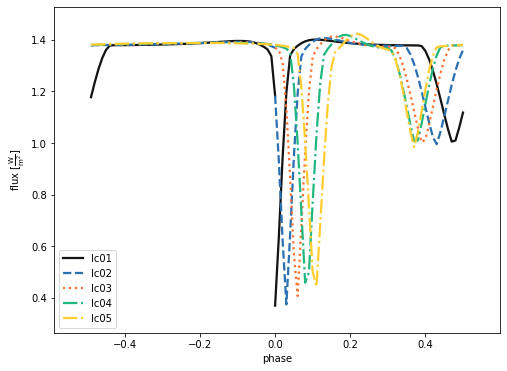

In [19]:
_ = b.plot(kind='lc', x='phases', show=True, legend=True)

To instead phase by the anomalistic period, we can pass `period='period_anom'` to the plot call.  (Note that these are being passed to [b.to_phase](../api/phoebe.frontend.bundle.Bundle.to_phase.md) under-the-hood).  Now we see the eclipses occur earlier and earlier with each cycle, with respect to the phase of periastron.



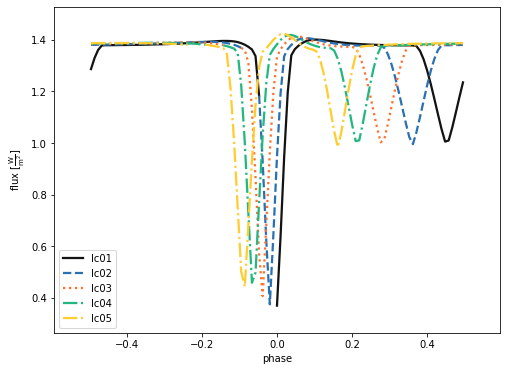

In [20]:
_ = b.plot(kind='lc', x='phases', period='period_anom', show=True, legend=True)

## Precession in Orbits

To visualize what is causing this, let's also plot the orbits.  We'll highlight the times of each expected periastron passage by passing a list of integer times (periastron will occur at `t0_perpass + N * period`)

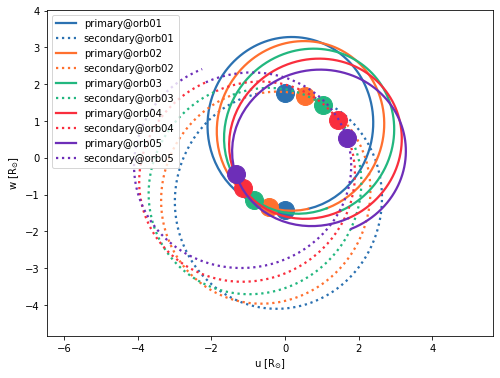

In [21]:
t0_perpass = b.get_value('t0_perpass', context='component')
period_anom = b.get_value('period_anom', component='binary', context='component')

_ = b.plot(kind='orb',
           x='us', y='ws', 
           time=t0_perpass+period_anom*np.arange(0,5), 
           linestyle={'primary': 'solid', 'secondary': 'dotted'}, 
           c={'orb01': 'blue', 'orb02': 'orange', 'orb03': 'green', 'orb04': 'red', 'orb05': 'purple'},
           legend=True,
           show=True)

To see the sidereal period phasing on the orbits, we could instead pass `t0_supconj + N * period_sidereal`.  These marked points are now the times in the orbit that are defined as zero-phase when passing `period='period_sidereal'` to [b.plot](../api/phoebe.parameters.ParameterSet.plot.md) or [b.to_phase](../api/phoebe.frontend.bundle.Bundle.to_phase.md) (and the default of `t0='t0_supconj'`, although this can also be changed by passing `t0` to either `b.plot` or `b.to_phase`).

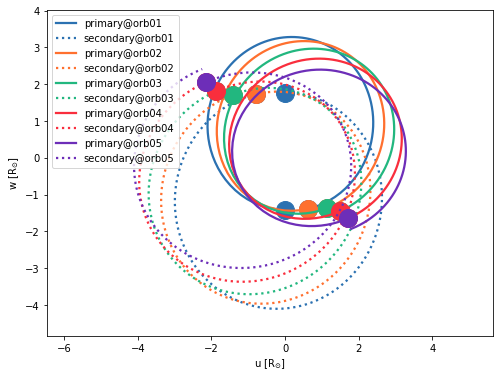

In [22]:
t0_supconj = b.get_value('t0_supconj', context='component')
period_sid = b.get_value('period', component='binary', context='component')

_ = b.plot(kind='orb',
           x='us', y='ws', 
           time=t0_supconj+period_sid*np.arange(0,5), 
           linestyle={'primary': 'solid', 'secondary': 'dotted'}, 
           c={'orb01': 'blue', 'orb02': 'orange', 'orb03': 'green', 'orb04': 'red', 'orb05': 'purple'},
           legend=True,
           show=True)

And if we plot only a single dataset, we can see that our `compute_phases` used `period` (sidereal) and therefore falls short of completing a full closed orbit.

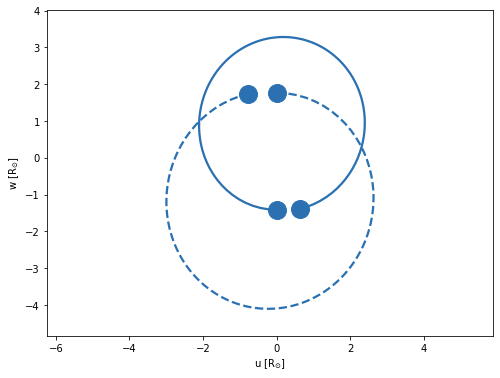

In [23]:
_ = b.plot(kind='orb', 
           dataset='orb01',
           x='us', y='ws', 
           time=t0_perpass+period_sid*np.arange(0,5), 
           c='blue',
           show=True)

## Considerations in compute_phases and mask_phases

If instead we wanted [compute_phases](compute_times_phases.ipynb) (and [mask_phases](mask_phases.ipynb)) to use `period_anom`, we could change the value of `phases_period` (only visible if `dperdt != 0.0`) in each dataset.

In [24]:
print(b.filter(qualifier='phases_period'))

ParameterSet: 10 parameters
       phases_period@lc01@dataset: period
      phases_period@orb01@dataset: period
       phases_period@lc02@dataset: period
      phases_period@orb02@dataset: period
       phases_period@lc03@dataset: period
      phases_period@orb03@dataset: period
       phases_period@lc04@dataset: period
      phases_period@orb04@dataset: period
       phases_period@lc05@dataset: period
      phases_period@orb05@dataset: period


In [25]:
print(b.get_parameter(qualifier='phases_period', dataset='lc01').description)

period to use when converting between compute_times and compute_phases as well as when applying mask_phases


In [26]:
print(b.get_parameter(qualifier='phases_period', dataset='lc01').choices)

['period', 'period_anom']


In [27]:
b.set_value_all('phases_period', 'period_anom')

And similarly, we could set `phases_t0` to be either `t0_perpass` or `t0_ref`.

In [28]:
print(b.get_parameter(qualifier='phases_t0', dataset='lc01').description)

t0 to use when converting between compute_times and compute_phases as well as when applying mask_phases


In [29]:
print(b.get_parameter(qualifier='phases_t0', dataset='lc01').choices)

['t0_supconj', 't0_perpass', 't0_ref']


Now if we re-run our model and plot the orbit, we'll see that the orbit now completes a full cycle from periastron to periastron, but is still not closed and overlaps in sky coordinates (for this case of a positive `dperdt`).

In [30]:
b.run_compute(irrad_method='none')

100%|██████████| 501/501 [00:31<00:00, 16.08it/s]


<ParameterSet: 81 parameters | kinds: orb, lc>

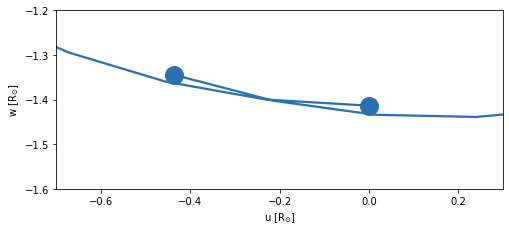

In [31]:
_ = b.plot(kind='orb', 
           dataset='orb01',
           x='us', y='ws', 
           time=t0_perpass+period_anom*np.arange(0,5), 
           c='blue',
           xlim=(-.7,0.3), ylim=(-1.6,-1.2),
           show=True)

## Synchronicity and Spots

If we look at the constraint relating the orbital (sidereal) period, stellar rotation period, and `syncpar`, we see that `syncpar` is defined as the ratio between the (sidereal) orbital and rotational period (wrt the sky).  In a non-precessing system, `syncpar == 1` results in stars that are co-rotating (at least for a circular orbit).  However, in a system with apsidal motion, `syncpar == 1` now means that the star is rotating (wrt the sky) at the same rate as the sidereal period.

In [32]:
print(b.filter(qualifier=['period', 'period_anom', 'syncpar'], component=['secondary', 'binary']))

ParameterSet: 6 parameters
      syncpar@secondary@component: 1.0
C      period@secondary@component: 0.9523809523809523 d
C         period@binary@component: 0.9523809523809523 d
     period_anom@binary@component: 1.0 d
         period@binary@constraint: {period_anom@binary@component} / ((({period_anom@binary@component} * {dperdt@binary@component}) / 6.283185307179586231995926937088) + 1.000000000000000000000000000000)
      period@secondary@constraint: {period@binary@component} / {syncpar@secondary@component}


If we now add a spot (see the [tutorial on spots](spots.ipynb) or the [spots in binaries example](../examples/binary_spots.ipynb)) to our primary component, we can track its relative position several sidereal and anomalistic cycles later.

In [33]:
b.add_feature('spot', component='secondary', relteff=0.9, radius=30, colat=90, long=180)

<ParameterSet: 5 parameters | contexts: compute, feature>

In [34]:
b.add_dataset('mesh', compute_times=[0.0, 4*period_sid, 4*period_anom], columns=['teffs'])

<ParameterSet: 85 parameters | contexts: dataset, figure, compute, constraint>

In [35]:
b.run_compute(irrad_method='none')

100%|██████████| 502/502 [00:33<00:00, 14.93it/s]


<ParameterSet: 113 parameters | kinds: mesh, orb, lc>

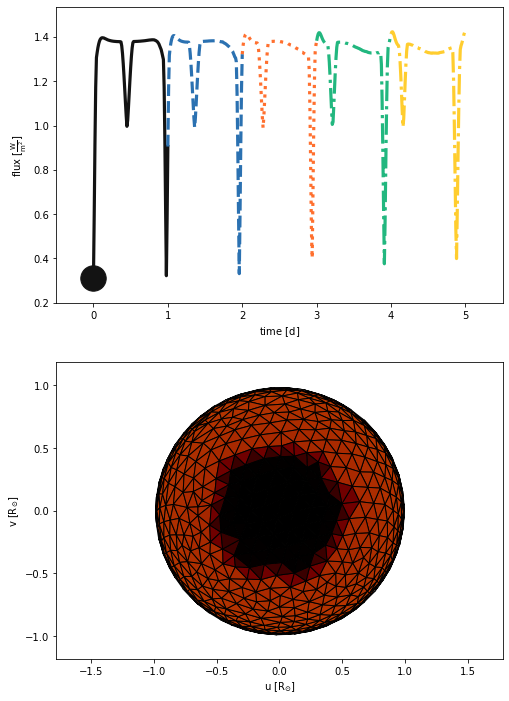

In [36]:
_ = b.plot(kind=['lc', 'mesh'], time=0.0, fc='teffs', show=True)

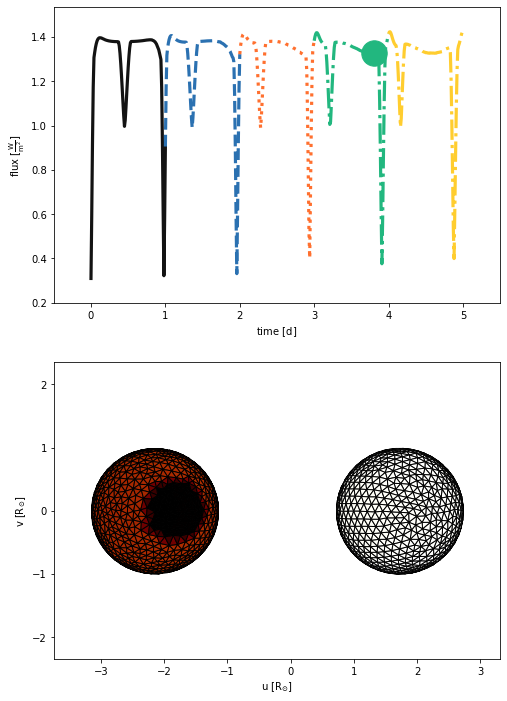

In [37]:
_ = b.plot(kind=['lc', 'mesh'], time=4*period_sid, fc='teffs', show=True)

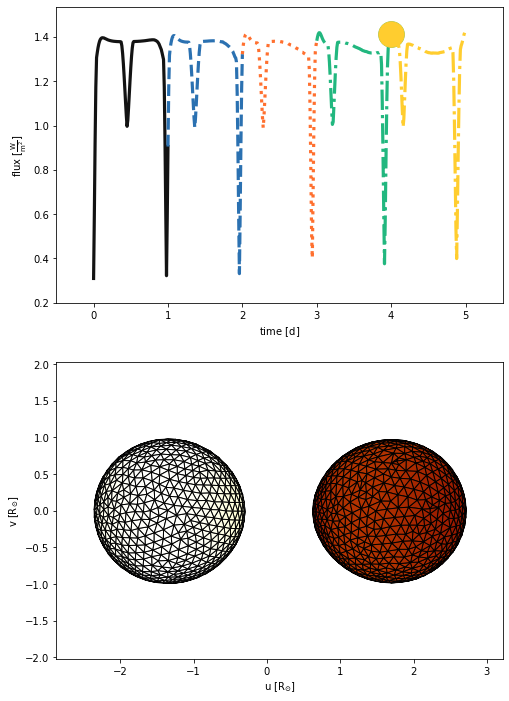

In [38]:
_ = b.plot(kind=['lc', 'mesh'], time=4*period_anom, fc='teffs', show=True)

We could now flip the constraint to instead provide the rotation period of the star.

In [39]:
b.flip_constraint('period@secondary', solve_for='syncpar')

<ConstraintParameter: {syncpar@secondary@component} = {period@binary@component} / {period@secondary@component} (solar units) => 1.0>

In [40]:
b.set_value('period', component='secondary', value=0.7)

In [41]:
print(b.filter(qualifier=['period', 'syncpar'], component=['binary', 'secondary']))

ParameterSet: 5 parameters
C     syncpar@secondary@component: 1.3605442176870748
       period@secondary@component: 0.7 d
C         period@binary@component: 0.9523809523809523 d
         period@binary@constraint: {period_anom@binary@component} / ((({period_anom@binary@component} * {dperdt@binary@component}) / 6.283185307179586231995926937088) + 1.000000000000000000000000000000)
               syncpar@constraint: {period@binary@component} / {period@secondary@component}


Now let's include this period when we compute the mesh models and see that the spot returns to the same position, relative to the plane of the sky, after one rotation period.

In [42]:
period_rot = b.get_value('period', component='secondary')
b.set_value('compute_times', dataset='mesh01', value=[0, 4*period_rot, 4*period_sid, 4*period_anom])

In [43]:
b.run_compute(irrad_method='none')

100%|██████████| 502/502 [00:33<00:00, 15.20it/s]


<ParameterSet: 123 parameters | kinds: mesh, orb, lc>

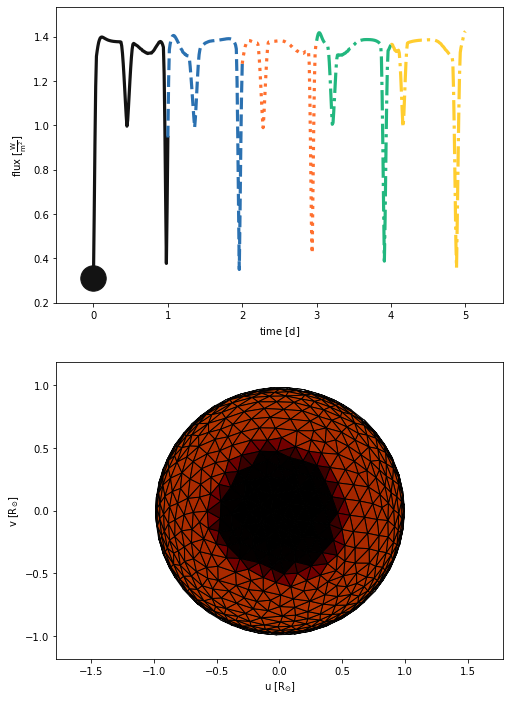

In [44]:
_ = b.plot(kind=['lc', 'mesh'], time=0.0, fc='teffs', show=True)

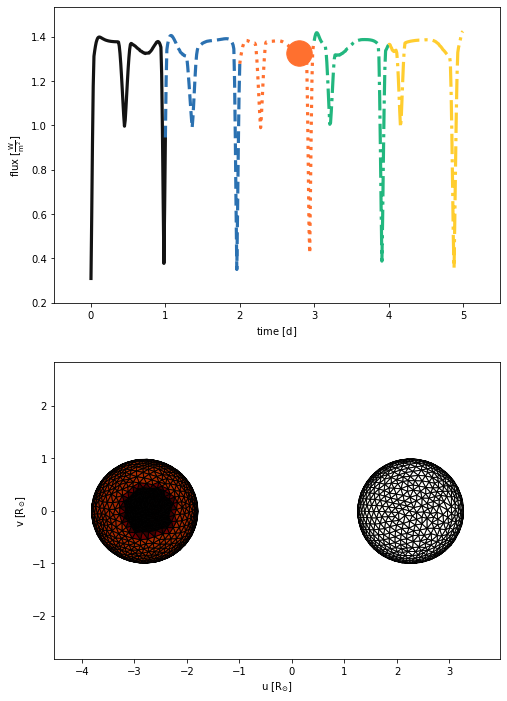

In [45]:
_ = b.plot(kind=['lc', 'mesh'], time=4*period_rot, fc='teffs', show=True)

## Kepler's Third Law

The [mass constraint](../api/phoebe.parameters.constraint.mass.md) which relates the masses of each star along with `q`, `sma`, and `period` via Kepler's third law uses the sidereal period.  It should be noted that the assumptions of Kepler's laws have been broken by adding apsidal motion (as the orbits are no longer closed ellipses), so the resulting masses (or whatever parameter are constrained if they have been flipped) are susceptible to these assumptions.

In [46]:
print(b.filter(qualifier=['mass']))

ParameterSet: 4 parameters
C          mass@primary@component: 1.223546091362142 solMass
C        mass@secondary@component: 0.9788368730897133 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * (1.000000 + {q@binary@component})) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * (1.000000 + (1.000000 / {q@binary@component}))) * 2942.206217504419328179210424423218)
